### Dog breed classification

In [14]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [15]:
!ls "/content/drive/My Drive/Colab Notebooks/dog_classifier/"

dog.ipynb  dogs


In [16]:
!pip3 install torch torchvision

  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [17]:
# I need these line to run the cell after (stackoverflow)
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


##### Import the necessary module

In [0]:
import torch
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import time
import json
import copy

from PIL import Image

import matplotlib.pyplot as plt
#%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [19]:
train_on_gpu = torch.cuda.is_available()

train_dir = "/content/drive/My Drive/Colab Notebooks/dog_classifier/dogs"
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.Resize(255), #square shape
                                transforms.CenterCrop(224), #square from the center of the image
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                     [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
classes = train_data.classes
f"classes: {len(classes)} - images: {len(train_data)}"

'classes: 120 - images: 20580'

#### Train and validation split

In [0]:
def train_valid_split(training_set, validation_size):
    """ Function that split our dataset into train and validation
        given in parameter the training set and the % of sample for validation"""
    
    # obtain training indices that will be used for validation
    num_train = len(training_set)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(validation_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    return train_sampler, valid_sampler

# Call it
valid_size = 0.3
train_sampler, valid_sampler = train_valid_split(train_data, valid_size)

#### Data loader

In [0]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=valid_sampler)

#### visualize image data

In [0]:
def visualise_image_data(data_loader, nb_images_to_display, classes): 
    
    # helper function to un-normalize and display an image
    def imshow(img):
        img = img / 2 + 0.5  # unnormalize
        plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

    # obtain one batch of training images
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    # convert images to numpy for display
    images = images.numpy()

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    # display 20 images
    for idx in np.arange(nb_images_to_display):
        ax = fig.add_subplot(2, nb_images_to_display/2, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(classes[labels[idx]])
        

#visualise_image_data(train_loader, 20, train_data.classes)

In [23]:
if not train_on_gpu:
    print('CUDA not available... Training on CPU')
else:
    print('CUDA available... Training on GPU')

CUDA available... Training on GPU


In [31]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 19954757.82it/s]


In [0]:
#model

In [40]:
print(f"input features: {model.fc.in_features}") 
print(f"output features: {model.fc.out_features}") 

input features: 512
output features: 1000


In [41]:
#model = models.vgg19(pretrained=True)
#print(f"input features: {model.classifier[6].in_features}") 
#print(f"output features: {model.classifier[6].out_features}") 

for param in model.parameters():
    param.requires_grad = False

n_inputs = model.fc.in_features

# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))
model.fc = last_layer


print(f"input features: {model.fc.in_features}") 
print(f"output features: {model.fc.out_features}") 

input features: 512
output features: 120


In [44]:
if train_on_gpu:
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum = 0.9)
#optimizer = optim.Adam(model.classifier.parameters(), lr=0.01)

model.fc

Linear(in_features=512, out_features=120, bias=True)

### Train

In [45]:
n_epochs = 12

# This is to make sure that the 1st loss is  lower than sth and
# Save the model according to this comparison
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
  
    # Pre-trained model by default is set to train
    for data, target in train_loader:
      
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()                                                    # Clear the gradient because it is saved at each step
        output = model(data)                                                     # Forward
        loss = criterion(output, target)                                         # Compute the loss
        loss.backward()                                                          # Compute the gradient
        optimizer.step()                                                         # Perform updates using calculated gradients
        train_loss += loss.item()*data.size(0)




    # Validation
    model.eval()
    for data, target in valid_loader:

        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)

    # print training/validation statistics 
    print(f"Epoch: {epoch} \tTraining Loss: {train_loss} \tValidation Loss: {valid_loss}")

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased ({valid_loss_min} --> {valid_loss}).  Saving model ...")
        torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/dog_classifier/model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 11.258298341133143 	Validation Loss: 4.159369619553571
Validation loss decreased (inf --> 4.159369619553571).  Saving model ...
Epoch: 2 	Training Loss: 3.238472611820744 	Validation Loss: 3.363288915527917
Validation loss decreased (4.159369619553571 --> 3.363288915527917).  Saving model ...
Epoch: 3 	Training Loss: 2.4786687095187756 	Validation Loss: 3.027306191816231
Validation loss decreased (3.363288915527917 --> 3.027306191816231).  Saving model ...
Epoch: 4 	Training Loss: 2.07024934853136 	Validation Loss: 3.046810354439088
Epoch: 5 	Training Loss: 1.7952386319538012 	Validation Loss: 2.9217399788026364
Validation loss decreased (3.027306191816231 --> 2.9217399788026364).  Saving model ...
Epoch: 6 	Training Loss: 1.6173912597854292 	Validation Loss: 2.928578448573542
Epoch: 7 	Training Loss: 1.454512832563232 	Validation Loss: 2.9521544127884307
Epoch: 8 	Training Loss: 1.3379905105365242 	Validation Loss: 2.967417995855598
Epoch: 9 	Training Loss: 1.

In [47]:
print("Model Loading...")
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/dog_classifier/model.pt'))
print("Model succefully loaded !")

Model Loading...
Model succefully loaded !


In [0]:
from PIL import Image
import numpy as np
import seaborn as sns

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image)
    
    # Resize image
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
        
    # Crop image
    bottom_margin = (img.height-224)/2
    top_margin = bottom_margin + 224
    left_margin = (img.width-224)/2
    right_margin = left_margin + 224
    
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    
    # Normalize image
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean)/std
    
    # move to first dimension --> PyTorch
    img = img.transpose((2, 0, 1))
    
    return img




def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [80]:
!ls '/content/drive/My Drive/Colab Notebooks/dog_classifier'

dog.ipynb  housetrain_adult_dog_hero.jpg  proportrait.jpg
dogs	   model.pt			  yorkshire-terrier.jpg


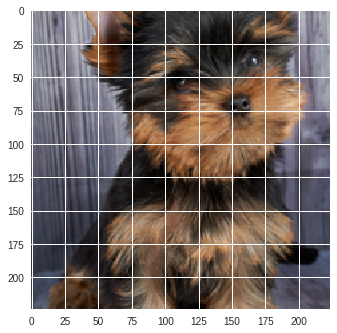

In [84]:
image_path = '/content/drive/My Drive/Colab Notebooks/dog_classifier/yorkshire-terrier.jpg'
img = process_image(image_path)
imshow(img)

In [0]:
def predict(image_path, model, imageFolderVariable, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    #process image
    img = process_image(image_path)
    #transform to tensor
    tensor_img = torch.from_numpy(img).type(torch.FloatTensor)
    #batch 1
    input_model = tensor_img.unsqueeze(0)

    # doesn't work on GPU, so I moved it to cpu
    model = model.cpu()
    log_results = model(input_model)
    proba = torch.exp(log_results)

    top_proba, top_label = proba.topk(top_k)
    top_proba = top_proba.detach().numpy().tolist()[0] 
    top_label = top_label.detach().numpy().tolist()[0]

    # transform indices to classes name
    idx_to_class = {val: key for key, val in imageFolderVariable.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_label]
    
    return top_proba, [i[10:] for i in top_labels]
  
 

def plot_solution(image_path, model):
    
    import seaborn as sns
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    
    # Plot 
    img = process_image(image_path)
    imshow(img, ax);
    
    # Make prediction
    probs, labs = predict(image_path, model, train_data)
    
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=labs, color=sns.color_palette()[0]);
    plt.show()

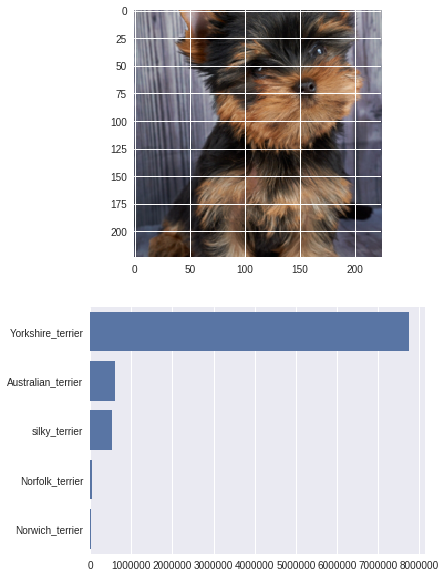

In [97]:
plot_solution(image_path, model)